In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print(x)
else:
    print("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
train_data= datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
test_data=datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

In [4]:
batch_size = 64
learning_rate = 1e-3

In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=4),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=3),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        
        x = self.decoder(x)

        x = x.view(-1, 1, 28, 28)
        return x

In [7]:
model = Autoencoder().to(mps_device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
from tqdm.notebook import tqdm

In [9]:
losses = []
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(mps_device), targets.to(mps_device)
        
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())


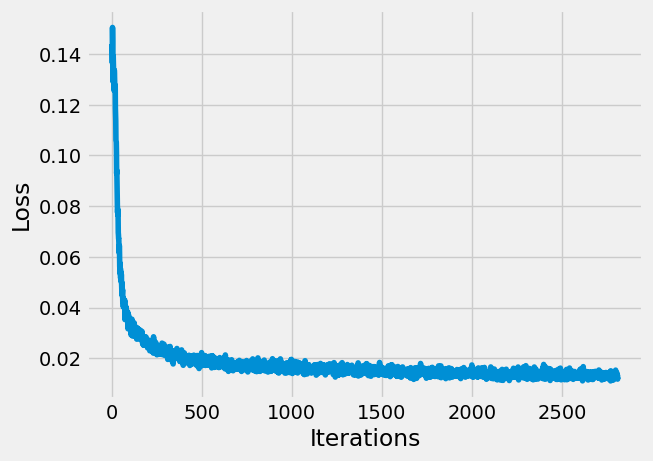

In [10]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.plot(losses)

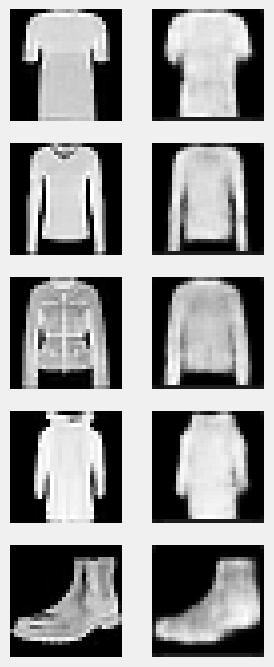

In [11]:
num_images = 5
for X, y in test_loader:
    X, y = X.to(mps_device), y.to(mps_device)
    with torch.no_grad():
        outputs = model(X)
        fig, ax = plt.subplots(num_images, 2, figsize=(3, 8))
        plt.gray()
        for j in range(num_images):
            ax[j][0].imshow(X[j, 0].cpu())
            ax[j][0].axis("off")
            ax[j][1].imshow(outputs[j, 0].cpu())
            ax[j][1].axis("off")
        plt.show()
    break